# Table of Contents
 <p><div class="lev1"><a href="#Cooler-quickstart">Cooler quickstart</a></div><div class="lev2"><a href="#Direct-access-with-h5py">Direct access with <code>h5py</code></a></div><div class="lev2"><a href="#The-Cooler-class">The <code>Cooler</code> class</a></div><div class="lev3"><a href="#The-info-dictionary">The info dictionary</a></div><div class="lev3"><a href="#Table-Views">Table Views</a></div><div class="lev3"><a href="#Enter-The-Matrix">Enter The Matrix</a></div><div class="lev3"><a href="#Genomic-coordinate-range-selection">Genomic coordinate range selection</a></div><div class="lev3"><a href="#Balancing-your-selection">Balancing your selection</a></div><div class="lev2"><a href="#Functional-API">Functional API</a></div>

# Cooler quickstart

In [1]:
from __future__ import division, print_function
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py

import cooler

In [4]:
!wget ftp://cooler.csail.mit.edu/coolers/hg19/Rao2014-GM12878-MboI-allreps-filtered.5kb.cool

--2016-08-13 21:07:22--  ftp://cooler.csail.mit.edu/coolers/hg19/Rao2014-GM12878-MboI-allreps-filtered.5kb.cool
           => ‘Rao2014-GM12878-MboI-allreps-filtered.5kb.cool’
Resolving cooler.csail.mit.edu (cooler.csail.mit.edu)... 128.52.129.246
Connecting to cooler.csail.mit.edu (cooler.csail.mit.edu)|128.52.129.246|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /coolers/hg19 ... done.
==> SIZE Rao2014-GM12878-MboI-allreps-filtered.5kb.cool ... 7443566184
==> PASV ... done.    ==> RETR Rao2014-GM12878-MboI-allreps-filtered.5kb.cool ... done.
Length: 7443566184 (6.9G) (unauthoritative)

Rao2014-GM12878-Mbo 100%[===================>]   6.93G  11.3MB/s    in 5m 6s   

2016-08-13 21:12:28 (23.2 MB/s) - ‘Rao2014-GM12878-MboI-allreps-filtered.5kb.cool’ saved [7443566184]



In [5]:
filepath = 'Rao2014-GM12878-MboI-allreps-filtered.5kb.cool'

## Direct access with `h5py`

The `h5py` library (HDF5 for Python) provides an excellent Pythonic interface between HDF5 and native [NumPy](http://www.numpy.org/) arrays and dtypes. It allows you to treat an HDF5 file like a dictionary with complete access to the file's contents as well as the ability to manipulate groups and read or write datasets and attributes. There is additionally a low-level API that wraps the `libhdf5` C functions directly. See the [h5py docs](http://docs.h5py.org/en/latest/index.html).

In [6]:
h5 = h5py.File(filepath, 'r')

In [7]:
h5

<HDF5 file "Rao2014-GM12878-MboI-allreps-filtered.5kb.cool" (mode r)>

In [8]:
h5.keys()

KeysViewWithLock(<HDF5 file "Rao2014-GM12878-MboI-allreps-filtered.5kb.cool" (mode r)>)

Files and Groups are `dict`-like.

In [9]:
h5['pixels']

<HDF5 group "/pixels" (3 members)>

In [10]:
list(h5['pixels'].keys())

['bin1_id', 'bin2_id', 'count']

`h5py` dataset objects are **views** onto the data on disk

In [11]:
h5['pixels']['bin2_id']

<HDF5 dataset "bin2_id": shape (1543535265,), type "<i8">

Slicing or indexing returns a numpy array in memory.

In [12]:
h5['pixels']['bin2_id'][:10]

array([  234,  1994,  3258,  4087,  6093, 37359, 49826, 49889, 58451, 60826])

In [13]:
h5['pixels']['count'][:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
h5.close()

The Python `cooler` package is just a thin wrapper over `h5py`.

- It lets you access the data tables as [Pandas](http://pandas.pydata.org/) [data frames and series](http://pandas.pydata.org/pandas-docs/stable/10min.html). 
- It also provides a _matrix abstraction_: letting you query the upper triangle pixel table as if it were a full rectangular [sparse matrix](http://www.scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html) via [SciPy](http://www.scipy-lectures.org/index.html).

See below.

## The `Cooler` class

Accepts a file path or an open HDF5 file object.

NOTE: Using a filepath allows the `Cooler` object to be serialized/pickled since the file is only opened when needed.


In [15]:
c = cooler.Cooler(filepath)

### The info dictionary

In [16]:
c.info

{'bin-size': 5000,
 'bin-type': 'fixed',
 'creation-date': '2016-02-25T22:53:09.510744',
 'format-url': 'https://github.com/mirnylab/cooler',
 'format-version': 2,
 'genome-assembly': 'hg19',
 'id': None,
 'library-version': '0.3.0',
 'metadata': {'QC': {'double-sided': {'filtered-invalid': {'removed-dangling-ends': 234897003,
     'removed-error-pair': 6074295,
     'removed-self-circles': 1741768},
    'filtered-valid': {'removed-duplicate': 110650005,
     'removed-large-small-pair': 657466,
     'removed-outlier-fragment': 151337031,
     'removed-start-near-rsite': ''},
    'total': 3390352656,
    'valid': 3147639590},
   'post-filtering': {'cis': 2085711027,
    'total': 2884995088,
    'trans': 799284061},
   'pre-filtering': {'double-sided': 3390352656,
    'single-sided': 1942368995,
    'total': 5332721651,
    'unused': 0}},
  'cell-type': 'GM12878',
  'enzyme': 'MboI',
  'publication': '',
  'sex': 'F',
  'species': 'Homo sapiens'},
 'nbins': 619150,
 'nchroms': 25,
 'nnz'

### Table Views
Tables are accessed via methods.

In [17]:
c.chroms()

The return value is a selector or "view" on a table that accepts column and range queries ("slices").

- Column selections return a new view.
- Range selections return pandas [DataFrames or Series](http://pandas.pydata.org/pandas-docs/stable/dsintro.html).

In [18]:
c.chroms()[1:5]

,name,length
1,chr2,243199373
2,chr3,198022430
3,chr4,191154276
4,chr5,180915260


In [19]:
# get the whole table
c.chroms()[:]

,name,length
0,chr1,249250621
1,chr2,243199373
2,chr3,198022430
3,chr4,191154276
4,chr5,180915260
5,chr6,171115067
6,chr7,159138663
7,chr8,146364022
8,chr9,141213431
9,chr10,135534747


In the bin table, the **weight** column contains the _matrix balancing weights_ computed for each genomic bin.

In [20]:
c.bins()[:10]

,chrom,start,end,weight
0,chr1,0,5000,NaN
1,chr1,5000,10000,NaN
2,chr1,10000,15000,NaN
3,chr1,15000,20000,NaN
4,chr1,20000,25000,NaN
5,chr1,25000,30000,NaN
6,chr1,30000,35000,NaN
7,chr1,35000,40000,NaN
8,chr1,40000,45000,NaN
9,chr1,45000,50000,NaN


Selecting a list of columns returns a new DataFrame view on that subset of columns

In [21]:
bins = c.bins()[['chrom', 'start', 'end']]
bins

In [22]:
bins[:10]

,chrom,start,end
0,chr1,0,5000
1,chr1,5000,10000
2,chr1,10000,15000
3,chr1,15000,20000
4,chr1,20000,25000
5,chr1,25000,30000
6,chr1,30000,35000
7,chr1,35000,40000
8,chr1,40000,45000
9,chr1,45000,50000


Selecting a single column returns a Series view

In [23]:
weights = c.bins()['weight']
weights

In [24]:
weights[100:110]

100   NaN
101   NaN
102   NaN
103   NaN
104   NaN
105   NaN
106   NaN
107   NaN
108   NaN
109   NaN
Name: weight, dtype: float64

The pixel table contains the non-zero upper triangle entries of the contact map.

In [25]:
c.pixels()[:10]

,bin1_id,bin2_id,count
0,2,234,1
1,2,1994,1
2,2,3258,1
3,2,4087,1
4,2,6093,1
5,2,37359,1
6,2,49826,1
7,2,49889,1
8,2,58451,1
9,2,60826,1


Use the `join=True` option if you would like to expand the bin IDs into genomic bin coordinates by joining the output with the bin table.

In [26]:
c.pixels(join=True)[:10]

,chrom1,start1,end1,chrom2,start2,end2,count
0,chr1,10000,15000,chr1,1170000,1175000,1
1,chr1,10000,15000,chr1,9970000,9975000,1
2,chr1,10000,15000,chr1,16290000,16295000,1
3,chr1,10000,15000,chr1,20435000,20440000,1
4,chr1,10000,15000,chr1,30465000,30470000,1
5,chr1,10000,15000,chr1,186795000,186800000,1
6,chr1,10000,15000,chr1,249130000,249135000,1
7,chr1,10000,15000,chr2,190000,195000,1
8,chr1,10000,15000,chr2,43000000,43005000,1
9,chr1,10000,15000,chr2,54875000,54880000,1


Pandas lets you readily dump any table selection to tabular text file.

In [27]:
df = c.pixels(join=True)[:100]

# tab-delimited file, don't write the index column or header row
df.to_csv('myselection.txt', sep='\t', index=False, header=False)

In [28]:
!head myselection.txt

chr1	10000	15000	chr1	1170000	1175000	1
chr1	10000	15000	chr1	9970000	9975000	1
chr1	10000	15000	chr1	16290000	16295000	1
chr1	10000	15000	chr1	20435000	20440000	1
chr1	10000	15000	chr1	30465000	30470000	1
chr1	10000	15000	chr1	186795000	186800000	1
chr1	10000	15000	chr1	249130000	249135000	1
chr1	10000	15000	chr2	190000	195000	1
chr1	10000	15000	chr2	43000000	43005000	1
chr1	10000	15000	chr2	54875000	54880000	1


### Enter The Matrix

Finally, the `matrix` method provides a 2D-sliceable view on the data. It allows you to query the data on file as a full rectangular contact matrix.

In [29]:
c.matrix()

The result of a query is a `scipy.sparse.coo_matrix` object.

In [30]:
mat = c.matrix()[1000:1200, 1000:1200]
mat

<200x200 sparse matrix of type '<class 'numpy.int64'>'
	with 39393 stored elements in COOrdinate format>

It is straightforward to convert to a dense 2D numpy array.

In [31]:
arr = mat.toarray()
arr

array([[129, 230,  72, ...,   3,   3,   3],
       [230, 217, 128, ...,   3,   6,   1],
       [ 72, 128,  42, ...,   3,   1,   1],
       ..., 
       [  3,   3,   3, ..., 199, 357, 165],
       [  3,   6,   1, ..., 357, 225, 257],
       [  3,   1,   1, ..., 165, 257, 136]])

Notice that the lower triangle has been automatically filled in.

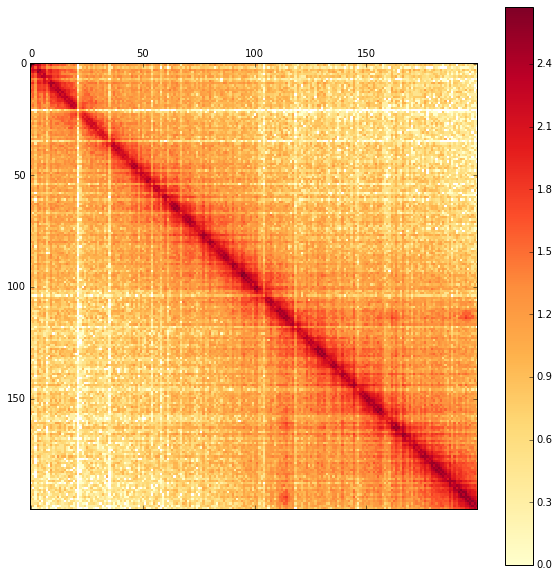

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='YlOrRd')
fig.colorbar(im)

### Genomic coordinate range selection

The bin table, pixel table and matrix views also accept UCSC-style genomic range strings or (chrom, start, end) triples.

In [33]:
c.bins().fetch('chr2:10,000,000-20,000,000')

,chrom,start,end,weight
51851,chr2,10000000,10005000,2.474065
51852,chr2,10005000,10010000,1.403127
51853,chr2,10010000,10015000,0.883045
51854,chr2,10015000,10020000,0.771122
51855,chr2,10020000,10025000,0.924510
51856,chr2,10025000,10030000,0.866517
51857,chr2,10030000,10035000,1.014915
51858,chr2,10035000,10040000,1.052058
51859,chr2,10040000,10045000,1.311514
51860,chr2,10045000,10050000,0.965850


In [34]:
cis = c.matrix().fetch('chr21')
trans = c.matrix().fetch('chr21', 'chr22')
trans.shape

(9626, 10261)

### Balancing your selection

Use the bin balancing weights to correct for biases.

In [35]:
# get the balancing weights as a numpy array
weights = c.bins()['weight']  # view
bias = weights[1000:1200]     # series
bias = bias.values            # array

# fetch a sparse matrix
mat = c.matrix()[1000:1200, 1000:1200]

# apply the balancing weights
mat.data = bias[mat.row] * bias[mat.col] * mat.data

# convert to numpy array
arr = mat.toarray()

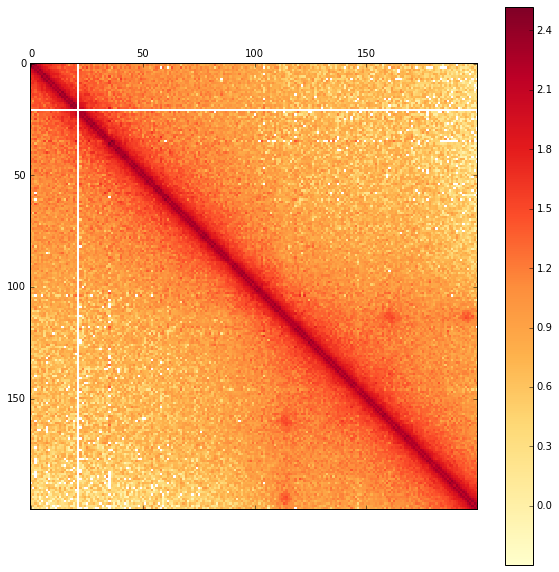

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='YlOrRd')
fig.colorbar(im)

## Functional API

Instead of the methods of the `Cooler` class, you can use the similarly named functions in the `cooler` module directly. However, they will only accept an open HDF5 file handle, not a file path string, and they execute their queries eagerly.

Open the HDF5 file with h5py

In [37]:
h5 = h5py.File(filepath, 'r')

In [38]:
cooler.info(h5)

{'bin-size': 5000,
 'bin-type': 'fixed',
 'creation-date': '2016-02-25T22:53:09.510744',
 'format-url': 'https://github.com/mirnylab/cooler',
 'format-version': 2,
 'genome-assembly': 'hg19',
 'id': None,
 'library-version': '0.3.0',
 'metadata': {'QC': {'double-sided': {'filtered-invalid': {'removed-dangling-ends': 234897003,
     'removed-error-pair': 6074295,
     'removed-self-circles': 1741768},
    'filtered-valid': {'removed-duplicate': 110650005,
     'removed-large-small-pair': 657466,
     'removed-outlier-fragment': 151337031,
     'removed-start-near-rsite': ''},
    'total': 3390352656,
    'valid': 3147639590},
   'post-filtering': {'cis': 2085711027,
    'total': 2884995088,
    'trans': 799284061},
   'pre-filtering': {'double-sided': 3390352656,
    'single-sided': 1942368995,
    'total': 5332721651,
    'unused': 0}},
  'cell-type': 'GM12878',
  'enzyme': 'MboI',
  'publication': '',
  'sex': 'F',
  'species': 'Homo sapiens'},
 'nbins': 619150,
 'nchroms': 25,
 'nnz'

In [39]:
cooler.bins(h5, 0, 10)

,chrom,start,end,weight
0,chr1,0,5000,NaN
1,chr1,5000,10000,NaN
2,chr1,10000,15000,NaN
3,chr1,15000,20000,NaN
4,chr1,20000,25000,NaN
5,chr1,25000,30000,NaN
6,chr1,30000,35000,NaN
7,chr1,35000,40000,NaN
8,chr1,40000,45000,NaN
9,chr1,45000,50000,NaN


... etc.

Note that `cooler.get()` is a very generic utility that lets you interpret a HDF5 group containing 1D datasets as a table.

In [40]:
print(cooler.get.__doc__)


    Query a range of rows from a table as a dataframe.

    A table is an HDF5 group containing equal-length 1D datasets serving as
    columns.

    Parameters
    ----------
    h5 : ``h5py.File`` or ``h5py.Group``
        Open handle to cooler file.
    table_name : str
        Name or path of HDF5 Group.
    lo, hi : int, optional
        Range of rows to select from the table.
    fields : str or sequence of str, optional
        Column or list of columns to query. Defaults to all available columns.
        A single string returns a Series instead of a DataFrame.
    convert_enum : bool, optional
        Whether to convert HDF5 enum datasets into ``pandas.Categorical``
        columns instead of plain integer columns. Default is True.
    kwargs : optional
        Options to pass to ``pandas.DataFrame`` or ``pandas.Series``.

    Returns
    -------
    DataFrame or Series

    Notes
    -----
    HDF5 ASCII datasets are converted to Unicode.

    
